[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dakimura/jquants-sample/blob/main/predictor.ipynb)

# J-Quants APIを用いた価格予測モデル生成

本ノートブックでは、data_retrieve.ipynbで保存したデータを用いて、
モデルの生成とそれによる価格の予測までを行います。

モデルには、J-Quantsファンダメンタルズ分析チャレンジで第2位を受賞された[UKIさんのモデル](https://github.com/UKI000/JQuants-Forum/blob/452a4f4bc086ef0a8b087efc707c51abad5ed50e/jquants01_fund_uki_predictor.py)を
ほぼそのまま使用させていただいています。

In [1]:
# 必要なライブラリのインストールとインポート
!pip install scikit-learn
!pip install xgboost pandas numpy

from datetime import datetime
import pandas as pd
import numpy as np
from dateutil import tz
import pickle
import os
import io
from typing import List

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

In [4]:
# 必要なコンフィグの定義
# データを保存しているGoogleドライブ上のディレクトリ
STORAGE_DIR_PATH = "/content/drive/MyDrive/drive_ws/marketdata"
# デバッグ中
# STORAGE_DIR_PATH = "/tmp/marketdata"

# CSVデータが保存されているファイルパス
stock_fin_csvfile_path = STORAGE_DIR_PATH + "/stock_fin.csv.gz"
stock_price_csvfile_path = STORAGE_DIR_PATH + "/stock_price.csv.gz"
# stock_labelsは今このノートブック内で作っているので特に保存する意味はないけれど
stock_labels_csvfile_path = STORAGE_DIR_PATH + "/stock_labels.csv.gz"
# 生成したモデルを保存するパス
model_dir = STORAGE_DIR_PATH + "/model/"

# トレーニング・検証データ期間
train_start_dt: datetime = datetime(2017, 1, 1)
train_end_dt: datetime = datetime(2020,11,30)

# 訓練結果を保存するファイルパス
model_path = STORAGE_DIR_PATH + "/model"

# テスト・評価期間
test_start_dt: datetime = datetime(2021, 1, 1)
test_end_dt: datetime = datetime(2022, 7, 31)

# デバッグ中は短い期間でチェック・・・
# train_start_dt: datetime = datetime(2022, 3, 1)
# train_end_dt: datetime = datetime(2022, 6,30)
# test_start_dt: datetime = datetime(2022, 7, 1)
# test_end_dt: datetime = datetime(2022, 7, 31)
# デバッグ用の銘柄
example_codes = [72030, 92010, 67580] # toyota, jal, sony (特に銘柄選定に意味はないです)


## データセットの読み込み

事前に生成しておいたcsvデータを読み込みます。

In [5]:
# ノートブックの冪等性を高めるためこれらの変数はこのセル以外でいじらない
stock_price:pd.DataFrame = pd.read_csv(stock_price_csvfile_path)
stock_fin:pd.DataFrame = pd.read_csv(stock_fin_csvfile_path)

# object型をdatetime64[ns]型に変換
stock_price["base_date"] = pd.to_datetime(stock_price["base_date"])
stock_price["EndOfDayQuote Date"] = pd.to_datetime(stock_price["EndOfDayQuote Date"])
stock_fin["base_date"] = pd.to_datetime(stock_fin["base_date"])
stock_fin["Result_FinancialStatement FiscalPeriodEnd"] = pd.to_datetime(stock_fin["Result_FinancialStatement FiscalPeriodEnd"])
stock_fin["Forecast_FinancialStatement FiscalPeriodEnd"] = pd.to_datetime(stock_fin["Forecast_FinancialStatement FiscalPeriodEnd"])

# Unnamedな列を削除しておく
stock_price = stock_price.loc[:, ~stock_price.columns.str.contains('^Unnamed')]
stock_fin = stock_fin.loc[:, ~stock_fin.columns.str.contains('^Unnamed')]

stock_fin.head()

,Local Code,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement ReportType,base_date,TypeOfDocument,RetrospectiveRestatement,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement NetIncome,Forecast_FinancialStatement OrdinaryIncome
0,27530,2017-03-31,2.238600e+10,1.829500e+10,2.276100e+10,2.147000e+09,2.234000e+09,1.494000e+09,3Q,2017-01-04,3QFinancialStatements_Consolidated_JP,False,2017-03-31,3Q,3.180000e+10,3.255000e+09,2.190000e+09,3.300000e+09
1,45750,2017-06-30,NaN,NaN,NaN,NaN,NaN,NaN,2Q,2017-01-04,ForecastRevision,NaN,2017-06-30,2Q,1.100000e+08,-4.650000e+08,-4.670000e+08,-4.660000e+08
2,33530,2017-02-28,2.510000e+10,7.566000e+09,2.212800e+10,8.200000e+08,7.780000e+08,6.290000e+08,3Q,2017-01-04,3QFinancialStatements_Consolidated_JP,False,2017-02-28,3Q,3.020000e+10,1.350000e+09,9.300000e+08,1.300000e+09
3,74630,2017-03-31,4.167600e+10,3.134800e+10,1.461900e+10,4.018000e+09,4.576000e+09,3.002000e+09,3Q,2017-01-05,3QFinancialStatements_Consolidated_JP,False,2017-03-31,3Q,2.150000e+10,6.400000e+09,4.400000e+09,6.700000e+09
4,99770,2017-02-28,2.760700e+10,1.767800e+10,7.893000e+10,1.786000e+09,1.845000e+09,1.059000e+09,3Q,2017-01-05,3QFinancialStatements_NonConsolidated_JP,False,2017-02-28,3Q,1.055000e+11,2.650000e+09,1.500000e+09,2.700000e+09


[株式分析チュートリアル](https://japanexchangegroup.github.io/J-Quants-Tutorial/#introduction)で用いられたデータの形式を[J-Quants API](https://jpx.gitbook.io/j-quants-api/api-reference)を用いて再現するため、データを加工します。

## 訓練とモデルの保存

特徴量と目的変数を生成し、訓練を行います。

In [6]:
# stock_priceを使ったテクニカル指標を各銘柄ごとに計算
def get_technical(stock_price:pd.DataFrame, code:int)->pd.DataFrame:
    technical_df = stock_price[stock_price["Local Code"] == code].copy()
    # 終値
    technical_df["close"] = technical_df["EndOfDayQuote Close"]
    # 騰落率
    technical_df["ror_1"] = technical_df["EndOfDayQuote Close"].pct_change(1)
    technical_df["ror_5"] = technical_df["EndOfDayQuote Close"].pct_change(5) # 5営業日前からの終値の変化率
    technical_df["ror_10"] = technical_df["EndOfDayQuote Close"].pct_change(10)
    technical_df["ror_20"] = technical_df["EndOfDayQuote Close"].pct_change(20)
    technical_df["ror_40"] = technical_df["EndOfDayQuote Close"].pct_change(40)
    technical_df["ror_60"] = technical_df["EndOfDayQuote Close"].pct_change(60)
    technical_df["ror_100"] = technical_df["EndOfDayQuote Close"].pct_change(100)

    # 売買代金
    technical_df["volume"] = technical_df["EndOfDayQuote Close"] * technical_df["EndOfDayQuote Volume"]
    technical_df = technical_df.replace([np.inf, -np.inf], np.nan)

    technical_df["vol_1"] = technical_df["volume"]
    technical_df["vol_5"] = technical_df["volume"].rolling(5).mean() # 5日移動平均
    technical_df["vol_10"] = technical_df["volume"].rolling(10).mean()
    technical_df["vol_20"] = technical_df["volume"].rolling(20).mean()
    technical_df["vol_40"] = technical_df["volume"].rolling(40).mean()
    technical_df["vol_60"] = technical_df["volume"].rolling(60).mean()
    technical_df["vol_100"] = technical_df["volume"].rolling(100).mean()
    technical_df["d_vol"] = technical_df["volume"] / technical_df["vol_20"]

    # レンジ (前日の終値に対して何%値動きしたか)
    technical_df["range"] = (
        technical_df[["EndOfDayQuote PreviousClose", "EndOfDayQuote High"]].max(axis=1) 
        - technical_df[["EndOfDayQuote PreviousClose", "EndOfDayQuote Low"]].min(axis=1)
        ) / technical_df["EndOfDayQuote PreviousClose"]
    technical_df = technical_df.replace([np.inf, -np.inf], np.nan)

    # レンジの移動平均
    technical_df["atr_1"] = technical_df["range"]
    technical_df["atr_5"] = technical_df["range"].rolling(5).mean()
    technical_df["atr_10"] = technical_df["range"].rolling(10).mean()
    technical_df["atr_20"] = technical_df["range"].rolling(20).mean()
    technical_df["atr_40"] = technical_df["range"].rolling(40).mean()
    technical_df["atr_60"] = technical_df["range"].rolling(60).mean()
    technical_df["atr_100"] = technical_df["range"].rolling(100).mean()
    technical_df["d_atr"] = technical_df["range"] / technical_df["atr_20"]

    # ギャップ (前日の終値よりも当日の始値がどれだけ値動きしたか) のレンジ
    technical_df["gap_range"] = (np.abs(technical_df["EndOfDayQuote Open"] - technical_df["EndOfDayQuote PreviousClose"])) / technical_df[
        "EndOfDayQuote PreviousClose"]
    technical_df["g_atr_1"] = technical_df["gap_range"]
    technical_df["g_atr_5"] = technical_df["gap_range"].rolling(5).mean()
    technical_df["g_atr_10"] = technical_df["gap_range"].rolling(10).mean()
    technical_df["g_atr_20"] = technical_df["gap_range"].rolling(20).mean()
    technical_df["g_atr_40"] = technical_df["gap_range"].rolling(40).mean()
    technical_df["g_atr_60"] = technical_df["gap_range"].rolling(60).mean()
    technical_df["g_atr_100"] = technical_df["gap_range"].rolling(100).mean()

    # デイレンジ
    technical_df["day_range"] = (technical_df["EndOfDayQuote High"] - technical_df["EndOfDayQuote Low"]) / technical_df[
        "EndOfDayQuote PreviousClose"]
    technical_df["d_atr_1"] = technical_df["day_range"]
    technical_df["d_atr_5"] = technical_df["day_range"].rolling(5).mean()
    technical_df["d_atr_10"] = technical_df["day_range"].rolling(10).mean()
    technical_df["d_atr_20"] = technical_df["day_range"].rolling(20).mean()
    technical_df["d_atr_40"] = technical_df["day_range"].rolling(40).mean()
    technical_df["d_atr_60"] = technical_df["day_range"].rolling(60).mean()
    technical_df["d_atr_100"] = technical_df["day_range"].rolling(100).mean()

    # ヒゲレンジ: ((高値-低値) - (始値と終値の差))/終値
    technical_df["hig_range"] = ((technical_df["EndOfDayQuote High"] - technical_df["EndOfDayQuote Low"]) - np.abs(
        technical_df["EndOfDayQuote Open"] - technical_df["EndOfDayQuote Close"])) / technical_df["EndOfDayQuote PreviousClose"]
    technical_df["h_atr_1"] = technical_df["hig_range"]
    technical_df["h_atr_5"] = technical_df["hig_range"].rolling(5).mean()
    technical_df["h_atr_10"] = technical_df["hig_range"].rolling(10).mean()
    technical_df["h_atr_20"] = technical_df["hig_range"].rolling(20).mean()
    technical_df["h_atr_40"] = technical_df["hig_range"].rolling(40).mean()
    technical_df["h_atr_60"] = technical_df["hig_range"].rolling(60).mean()
    technical_df["h_atr_100"] = technical_df["hig_range"].rolling(100).mean()

    # ボラティリティ
    technical_df["vola_5"] = technical_df["ror_1"].rolling(5).std()
    technical_df["vola_10"] = technical_df["ror_1"].rolling(10).std()
    technical_df["vola_20"] = technical_df["ror_1"].rolling(20).std()
    technical_df["vola_40"] = technical_df["ror_1"].rolling(40).std()
    technical_df["vola_60"] = technical_df["ror_1"].rolling(60).std()
    technical_df["vola_100"] = technical_df["ror_1"].rolling(100).std()

    # HL(High-Low)バンド: 直近n日の高値（Hバンド）、安値（Lバンド）
    technical_df["hl_5"] = technical_df["EndOfDayQuote High"].rolling(5).max() - technical_df["EndOfDayQuote Low"].rolling(5).min()
    technical_df["hl_10"] = technical_df["EndOfDayQuote High"].rolling(10).max() - technical_df["EndOfDayQuote Low"].rolling(10).min()
    technical_df["hl_20"] = technical_df["EndOfDayQuote High"].rolling(20).max() - technical_df["EndOfDayQuote Low"].rolling(20).min()
    technical_df["hl_40"] = technical_df["EndOfDayQuote High"].rolling(40).max() - technical_df["EndOfDayQuote Low"].rolling(40).min()
    technical_df["hl_60"] = technical_df["EndOfDayQuote High"].rolling(60).max() - technical_df["EndOfDayQuote Low"].rolling(60).min()
    technical_df["hl_100"] = technical_df["EndOfDayQuote High"].rolling(100).max() - technical_df["EndOfDayQuote Low"].rolling(100).min()

    # マーケットインパクト
    technical_df["mi"] = technical_df["range"] / (technical_df["EndOfDayQuote Volume"] * technical_df["EndOfDayQuote Close"])
    technical_df = technical_df.replace([np.inf, -np.inf], np.nan) # "EndOfDayQuote Volume"=0の場合への考慮

    technical_df["mi_5"] = technical_df["mi"].rolling(5).mean()
    technical_df["mi_10"] = technical_df["mi"].rolling(10).mean()
    technical_df["mi_20"] = technical_df["mi"].rolling(20).mean()
    technical_df["mi_40"] = technical_df["mi"].rolling(40).mean()
    technical_df["mi_60"] = technical_df["mi"].rolling(60).mean()
    technical_df["mi_100"] = technical_df["mi"].rolling(100).mean()

    feat = ["EndOfDayQuote Date", "Local Code", "close",
            "ror_1", "ror_5", "ror_10", "ror_20", "ror_40", "ror_60", "ror_100",
            "vol_1", "vol_5", "vol_10", "vol_20", "vol_40", "vol_60", "vol_100", "d_vol",
            "atr_1", "atr_5", "atr_10", "atr_20", "atr_40", "atr_60", "atr_100", "d_atr",
            "g_atr_1", "g_atr_5", "g_atr_10", "g_atr_20", "g_atr_40", "g_atr_60", "g_atr_100",
            "d_atr_1", "d_atr_5", "d_atr_10", "d_atr_20", "d_atr_40", "d_atr_60", "d_atr_100",
            "h_atr_1", "h_atr_5", "h_atr_10", "h_atr_20", "h_atr_40", "h_atr_60", "h_atr_100",
            "vola_5", "vola_10", "vola_20", "vola_40", "vola_60", "vola_100",
            "hl_5", "hl_10", "hl_20", "hl_40", "hl_60", "hl_100",
            "mi_5", "mi_10", "mi_20", "mi_40", "mi_60", "mi_100"]
    technical_df = technical_df[feat]
    technical_df.columns = ["datetime", "code", "close",
                      "ror_1", "ror_5", "ror_10", "ror_20", "ror_40", "ror_60", "ror_100",
                      "vol_1", "vol_5", "vol_10", "vol_20", "vol_40", "vol_60", "vol_100", "d_vol",
                      "atr_1", "atr_5", "atr_10", "atr_20", "atr_40", "atr_60", "atr_100", "d_atr",
                      "g_atr_1", "g_atr_5", "g_atr_10", "g_atr_20", "g_atr_40", "g_atr_60", "g_atr_100",
                      "d_atr_1", "d_atr_5", "d_atr_10", "d_atr_20", "d_atr_40", "d_atr_60", "d_atr_100",
                      "h_atr_1", "h_atr_5", "h_atr_10", "h_atr_20", "h_atr_40", "h_atr_60", "h_atr_100",
                      "vola_5", "vola_10", "vola_20", "vola_40", "vola_60", "vola_100",
                      "hl_5", "hl_10", "hl_20", "hl_40", "hl_60", "hl_100",
                      "mi_5", "mi_10", "mi_20", "mi_40", "mi_60", "mi_100"]
    technical_df["datetime"] = pd.to_datetime(technical_df["datetime"])
    technical_df = technical_df.set_index(["datetime", "code"])
    return technical_df

# example
get_technical(stock_price, example_codes[0]).head()

,,close,ror_1,ror_5,ror_10,ror_20,ror_40,ror_60,ror_100,vol_1,vol_5,vol_10,vol_20,vol_40,vol_60,vol_100,d_vol,atr_1,atr_5,atr_10,atr_20,atr_40,atr_60,atr_100,d_atr,g_atr_1,g_atr_5,g_atr_10,g_atr_20,g_atr_40,g_atr_60,g_atr_100,d_atr_1,d_atr_5,d_atr_10,d_atr_20,d_atr_40,d_atr_60,d_atr_100,h_atr_1,h_atr_5,h_atr_10,h_atr_20,h_atr_40,h_atr_60,h_atr_100,vola_5,vola_10,vola_20,vola_40,vola_60,vola_100,hl_5,hl_10,hl_20,hl_40,hl_60,hl_100,mi_5,mi_10,mi_20,mi_40,mi_60,mi_100
datetime,code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-04,72030,1419.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.775932e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,72030,1409.8,-0.006763,NaN,NaN,NaN,NaN,NaN,NaN,5.388256e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000986,NaN,NaN,NaN,NaN,NaN,NaN,0.009582,NaN,NaN,NaN,NaN,NaN,NaN,0.003804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,72030,1386.0,-0.016882,NaN,NaN,NaN,NaN,NaN,NaN,8.029167e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029650,NaN,NaN,NaN,NaN,NaN,NaN,0.016740,NaN,NaN,NaN,NaN,NaN,NaN,0.003972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,72030,1372.2,-0.009957,NaN,NaN,NaN,NaN,NaN,NaN,6.127628e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001154,NaN,NaN,NaN,NaN,NaN,NaN,0.013997,NaN,NaN,NaN,NaN,NaN,NaN,0.005195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,72030,1382.4,0.007433,NaN,NaN,NaN,NaN,NaN,NaN,4.565583e+10,6.177313e+10,NaN,NaN,NaN,NaN,NaN,NaN,0.009182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005539,NaN,NaN,NaN,NaN,NaN,NaN,0.007142,NaN,NaN,NaN,NaN,NaN,NaN,0.005247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# stock_finを使った指標を各銘柄ごとに計算
def get_financial(stock_fin:pd.DataFrame, code:int)->pd.DataFrame:
    fin_df = stock_fin[stock_fin["Local Code"] == code].copy()

    # TypeOfDocumentの値によってはTotalAssetsなどの値がNaNになっているのでffill
    fin_df = fin_df.ffill()

    # --- 本決算／中間決算フラグ、修正開示フラグ、事後修正有無フラグ ---
    fin_df["annual"] = 0 # 0: 中間決算, 1:本決算
    fin_df["revision"] = 0 # 1: 修正再表示
    # FYFinancialStatements*** は本決算
    fin_df.loc[fin_df["TypeOfDocument"].isin(["FYFinancialStatements_Consolidated_JP", "FYFinancialStatements_Consolidated_US", "FYFinancialStatements_Consolidated_IFRS"]), "annual"] = 1
    fin_df.loc[fin_df["RetrospectiveRestatement"]==True, "revision"] = 1
    feat1 = ["annual", "revision"]

    # --- 原系列 ---
    # (memo: 前期と当期を比較すると季節的な変動が含まれ、経済的な変動を評価しづらくなる。この季節的な変動を取り除く前のものを原系列と呼ぶ)

    # --- r_sales ---
    # pre_result_period_end: 前回の情報開示日時点における事業年度終了日
    fin_df["pre_result_period_end"] = fin_df["Result_FinancialStatement FiscalPeriodEnd"].shift(1)
    fin_df["r_sales"] = np.nan

    # 前の行から会計年度が変わったけどReportTypeが1Qでない = 年度の途中からのデータを見ており一番最初のレコードが2Qとか3Qのものだったとき?よくわかってない
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_sales"] = fin_df[
        "Result_FinancialStatement NetSales"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_sales"] = fin_df[
        "Result_FinancialStatement NetSales"]
    fin_df["r_sales"] = fin_df["r_sales"].ffill()

    # --- r_ope_income ---
    fin_df["r_ope_income"] = np.nan
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_ope_income"] = fin_df[
        "Result_FinancialStatement OperatingIncome"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_ope_income"] = fin_df[
        "Result_FinancialStatement OperatingIncome"]
    fin_df["r_ope_income"] = fin_df["r_ope_income"].ffill()

    # --- r_ord_income ---
    fin_df["r_ord_income"] = np.nan
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_ord_income"] = fin_df[
        "Result_FinancialStatement OrdinaryIncome"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_ord_income"] = fin_df[
        "Result_FinancialStatement OrdinaryIncome"]
    fin_df["r_ord_income"] = fin_df["r_ord_income"].ffill()

    # --- r_net_income ---
    fin_df["r_net_income"] = np.nan
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_net_income"] = fin_df[
        "Result_FinancialStatement NetIncome"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_net_income"] = fin_df[
        "Result_FinancialStatement NetIncome"]
    fin_df["r_net_income"] = fin_df["r_net_income"].ffill()

    # --- pre_forcast_period_end ---
    fin_df["pre_forecast_period_end"] = fin_df["Forecast_FinancialStatement FiscalPeriodEnd"].shift(1)

    # --- f_sales ---
    fin_df["f_sales"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_sales"] = fin_df[
        "Forecast_FinancialStatement NetSales"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_sales"] = fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_sales"] = fin_df["f_sales"].ffill()

    # --- f_ope_income ---
    fin_df["f_ope_income"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_ope_income"] = fin_df[
        "Forecast_FinancialStatement OperatingIncome"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_ope_income"] = fin_df[
        "Forecast_FinancialStatement OperatingIncome"]
    fin_df["f_ope_income"] = fin_df["f_ope_income"].ffill()

    # --- f_ord_income ---
    fin_df["f_ord_income"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_ord_income"] = fin_df[
        "Forecast_FinancialStatement OrdinaryIncome"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_ord_income"] = fin_df[
        "Forecast_FinancialStatement OrdinaryIncome"]
    fin_df["f_ord_income"] = fin_df["f_ord_income"].ffill()

    # --- f_net_income ---
    fin_df["f_net_income"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_net_income"] = fin_df[
        "Forecast_FinancialStatement NetIncome"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_net_income"] = fin_df[
        "Forecast_FinancialStatement NetIncome"]
    fin_df["f_net_income"] = fin_df["f_net_income"].ffill()

    # --------------------
    fin_df["r_expense1"] = fin_df["r_sales"] - fin_df["r_ope_income"]
    fin_df["r_expense2"] = fin_df["r_ope_income"] - fin_df["r_ord_income"]
    fin_df["r_expense3"] = fin_df["r_ord_income"] - fin_df["r_net_income"]

    fin_df["f_expense1"] = fin_df["f_sales"] - fin_df["f_ope_income"]
    fin_df["f_expense2"] = fin_df["f_ope_income"] - fin_df["f_ord_income"]
    fin_df["f_expense3"] = fin_df["f_ord_income"] - fin_df["f_net_income"]

    fin_df["r_assets"] = fin_df["Result_FinancialStatement TotalAssets"]
    fin_df["r_equity"] = fin_df["Result_FinancialStatement NetAssets"]

    # 現在 J-Quants APIからは取れなさそう
    # fin_df["operating_cf"] = fin_df["Result_FinancialStatement CashFlowsFromOperatingActivities"]
    # fin_df["financial_cf"] = fin_df["Result_FinancialStatement CashFlowsFromFinancingActivities"]
    # fin_df["investing_cf"] = fin_df["Result_FinancialStatement CashFlowsFromInvestingActivities"]

    feat2 = ["r_sales", "r_ope_income", "r_ord_income", "r_net_income", "f_sales", "f_ope_income", "f_ord_income",
            "f_net_income",
            "r_expense1", "r_expense2", "r_expense3", "f_expense1", "f_expense2", "f_expense3",
            "r_assets", "r_equity",] #"operating_cf", "financial_cf", "investing_cf"]


    # --- 複合指標　原系列 ---
    # ------ 純利益系 ------
    fin_df["r_pm1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df["Result_FinancialStatement NetSales"]
    fin_df["r_roe1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df["Result_FinancialStatement NetAssets"]
    fin_df["r_roa1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    fin_df["f_pm1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_roe1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["f_roa1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 経常利益系
    fin_df["r_pm2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement NetSales"]
    fin_df["r_roe2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["r_roa2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    fin_df["f_pm2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_roe2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["f_roa2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 営業利益系
    fin_df["r_pm3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement NetSales"]
    fin_df["r_roe3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["r_roa3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    fin_df["f_pm3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_roe3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["f_roa3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # コスト
    fin_df["r_cost1"] = ((fin_df["Result_FinancialStatement NetSales"] - fin_df[
        "Result_FinancialStatement OperatingIncome"]) / fin_df["Result_FinancialStatement NetSales"])
    fin_df["r_cost2"] = ((fin_df["Result_FinancialStatement OperatingIncome"] - fin_df[
        "Result_FinancialStatement OrdinaryIncome"]) / fin_df["Result_FinancialStatement NetSales"])
    fin_df["r_cost3"] = ((fin_df["Result_FinancialStatement OrdinaryIncome"] - fin_df[
        "Result_FinancialStatement NetIncome"]) / fin_df["Result_FinancialStatement NetSales"])

    fin_df["f_cost1"] = ((fin_df["Forecast_FinancialStatement NetSales"] - fin_df[
        "Forecast_FinancialStatement OperatingIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])
    fin_df["f_cost2"] = ((fin_df["Forecast_FinancialStatement OperatingIncome"] - fin_df[
        "Forecast_FinancialStatement OrdinaryIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])
    fin_df["f_cost3"] = ((fin_df["Forecast_FinancialStatement OrdinaryIncome"] - fin_df[
        "Forecast_FinancialStatement NetIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])

    # 売上高回転率
    fin_df["r_turn"] = fin_df["Result_FinancialStatement NetSales"] / fin_df[
        "Result_FinancialStatement TotalAssets"]
    fin_df["f_turn"] = fin_df["Forecast_FinancialStatement NetSales"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 財務健全性
    fin_df["equity_ratio"] = fin_df["Result_FinancialStatement NetAssets"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 総資本キャッシュフロー比率 --- 現在J-Quants APIからは取得できなさそう
    # fin_df["o_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromOperatingActivities"] / fin_df[
    #     "Result_FinancialStatement TotalAssets"])
    # fin_df["f_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromFinancingActivities"] / fin_df[
    #     "Result_FinancialStatement TotalAssets"])
    # fin_df["i_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromInvestingActivities"] / fin_df[
    #     "Result_FinancialStatement TotalAssets"])

    feat3 = ["r_pm1", "r_roe1", "r_roa1", "f_pm1", "f_roe1", "f_roa1",
             "r_pm2", "r_roe2", "r_roa2", "f_pm2", "f_roe2", "f_roa2",
             "r_pm3", "r_roe3", "r_roa3", "f_pm3", "f_roe3", "f_roa3",
             "r_cost1", "r_cost2", "r_cost3", "f_cost1", "f_cost2", "f_cost3",
             "r_turn", "f_turn", "equity_ratio", ] # "o_cf_ratio", "f_cf_ratio", "i_cf_ratio"]

    # Inf値をNan値化
    fin_df = fin_df.replace([np.inf, -np.inf], np.nan)

    # 差分系列
    d_feat2 = []

    for f in feat2:
        fin_df["d_" + f] = fin_df[f].diff(1)
        d_feat2.append("d_" + f)

    d_feat3 = []
    for f in feat3:
        fin_df["d_" + f] = fin_df[f].diff(1)
        d_feat3.append("d_" + f)

    d_feat4 = ["m_sales", "m_ope_income", "m_ord_income", "m_net_income", "m_expense1", "m_expense2", "m_expense3",
               "m_pm1", "m_pm2", "m_pm3", "m_roe1", "m_roe2", "m_roe3", "m_roa1", "m_roa2", "m_roa3",
               "m_cost1", "m_cost2", "m_cost3"]

    fin_df["m_sales"] = fin_df["r_sales"] - fin_df["f_sales"].shift(1)
    fin_df["m_ope_income"] = fin_df["r_ope_income"] - fin_df["f_ope_income"].shift(1)
    fin_df["m_ord_income"] = fin_df["r_ord_income"] - fin_df["f_ord_income"].shift(1)
    fin_df["m_net_income"] = fin_df["r_net_income"] - fin_df["f_net_income"].shift(1)
    fin_df["m_expense1"] = fin_df["r_expense1"] - fin_df["f_expense1"].shift(1)
    fin_df["m_expense2"] = fin_df["r_expense2"] - fin_df["f_expense2"].shift(1)
    fin_df["m_expense3"] = fin_df["r_expense3"] - fin_df["f_expense3"].shift(1)

    fin_df["m_pm1"] = fin_df["r_pm1"] - fin_df["f_pm1"].shift(1)
    fin_df["m_pm2"] = fin_df["r_pm2"] - fin_df["f_pm2"].shift(1)
    fin_df["m_pm3"] = fin_df["r_pm3"] - fin_df["f_pm3"].shift(1)
    fin_df["m_roe1"] = fin_df["r_roe1"] - fin_df["f_roe1"].shift(1)
    fin_df["m_roe2"] = fin_df["r_roe2"] - fin_df["f_roe2"].shift(1)
    fin_df["m_roe3"] = fin_df["r_roe3"] - fin_df["f_roe3"].shift(1)
    fin_df["m_roa1"] = fin_df["r_roa1"] - fin_df["f_roa1"].shift(1)
    fin_df["m_roa2"] = fin_df["r_roa2"] - fin_df["f_roa2"].shift(1)
    fin_df["m_roa3"] = fin_df["r_roa3"] - fin_df["f_roa3"].shift(1)
    fin_df["m_cost1"] = fin_df["r_cost1"] - fin_df["f_cost1"].shift(1)
    fin_df["m_cost2"] = fin_df["r_cost2"] - fin_df["f_cost2"].shift(1)
    fin_df["m_cost3"] = fin_df["r_cost3"] - fin_df["f_cost3"].shift(1)

    feat = ["base_date", "Local Code"]
    feat.extend(feat1)
    feat.extend(feat2)
    feat.extend(feat3)
    feat.extend(d_feat2)
    feat.extend(d_feat3)
    feat.extend(d_feat4)

    col_names = ["datetime", "code"]
    col_names.extend(feat1)
    col_names.extend(feat2)
    col_names.extend(feat3)
    col_names.extend(d_feat2)
    col_names.extend(d_feat3)
    col_names.extend(d_feat4)

    fin_df = fin_df[feat]
    fin_df.columns = col_names
    fin_df["datetime"] = pd.to_datetime(fin_df["datetime"])
    fin_df = fin_df.set_index(["datetime", "code"])
    return fin_df

# example
get_financial(stock_fin, example_codes[1]).head()

,,annual,revision,r_sales,r_ope_income,r_ord_income,r_net_income,f_sales,f_ope_income,f_ord_income,f_net_income,r_expense1,r_expense2,r_expense3,f_expense1,f_expense2,f_expense3,r_assets,r_equity,r_pm1,r_roe1,r_roa1,f_pm1,f_roe1,f_roa1,r_pm2,r_roe2,r_roa2,f_pm2,f_roe2,f_roa2,r_pm3,r_roe3,r_roa3,f_pm3,f_roe3,f_roa3,r_cost1,r_cost2,r_cost3,f_cost1,f_cost2,f_cost3,r_turn,f_turn,equity_ratio,d_r_sales,d_r_ope_income,d_r_ord_income,d_r_net_income,d_f_sales,d_f_ope_income,d_f_ord_income,d_f_net_income,d_r_expense1,d_r_expense2,d_r_expense3,d_f_expense1,d_f_expense2,d_f_expense3,d_r_assets,d_r_equity,d_r_pm1,d_r_roe1,d_r_roa1,d_f_pm1,d_f_roe1,d_f_roa1,d_r_pm2,d_r_roe2,d_r_roa2,d_f_pm2,d_f_roe2,d_f_roa2,d_r_pm3,d_r_roe3,d_r_roa3,d_f_pm3,d_f_roe3,d_f_roa3,d_r_cost1,d_r_cost2,d_r_cost3,d_f_cost1,d_f_cost2,d_f_cost3,d_r_turn,d_f_turn,d_equity_ratio,m_sales,m_ope_income,m_ord_income,m_net_income,m_expense1,m_expense2,m_expense3,m_pm1,m_pm2,m_pm3,m_roe1,m_roe2,m_roe3,m_roa1,m_roa2,m_roa3,m_cost1,m_cost2,m_cost3
datetime,code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-31,92010,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.625318e+12,9.534070e+11,0.111003,0.113574,0.066622,0.125781,0.168868,0.099058,0.139486,0.142717,0.083717,0.127344,0.170966,0.100288,0.140761,0.144021,0.084483,0.132812,0.178308,0.104595,0.859239,0.001275,0.028483,0.867188,0.005469,0.001563,0.600183,0.787538,0.586597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-28,92010,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.728777e+12,1.003393e+12,0.127369,0.163619,0.094965,0.074683,0.099662,0.057844,0.128020,0.164455,0.095451,0.102315,0.136537,0.079247,0.132146,0.169756,0.098527,0.106049,0.141520,0.082139,0.867854,0.004127,0.000651,0.893951,0.003734,0.027633,0.745595,0.774536,0.580406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.034590e+11,4.998600e+10,0.016366,0.050045,0.028343,-0.051099,-0.069206,-0.041213,-0.011467,0.021738,0.011734,-0.025029,-0.034429,-0.021041,-0.008615,0.025735,0.014045,-0.026763,-0.036788,-0.022456,0.008615,0.002851,-0.027832,0.026763,-0.001735,0.026070,0.145412,-0.013002,-0.006191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001587,0.000676,-0.000666,-0.005249,-0.006511,-0.008552,-0.004092,-0.004837,-0.006067,0.000666,-0.001342,-0.000912
2017-07-31,92010,0,0,3.148150e+11,2.474700e+10,2.455300e+10,1.956300e+10,1.348000e+12,1.530000e+11,1.460000e+11,1.080000e+11,2.900680e+11,194000000.0,4.990000e+09,1.195000e+12,7.000000e+09,3.800000e+10,1.731338e+12,9.888990e+11,0.062141,0.019783,0.011299,0.080119,0.109212,0.062380,0.077992,0.024829,0.014182,0.108309,0.147639,0.084328,0.078608,0.025025,0.014294,0.113501,0.154718,0.088371,0.921392,0.000616,0.015851,0.886499,0.005193,0.028190,0.181833,0.778589,0.571176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.561000e+09,-1.449400e+10,-0.065227,-0.143836,-0.083666,0.005436,0.009551,0.004535,-0.050028,-0.139626,-0.081269,0.005993,0.011102,0.005081,-0.053538,-0.144731,-0.084234,0.007452,0.013198,0.006232,0.053538,-0.003510,0.015200,-0.007452,0.001459,0.000557,-0.563761,0.004053,-0.009230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012541,-0.024323,-0.027441,-0.079879,-0.111708,-0.116495,-0.046545,-0.065065,-0.067845,0.027441,-0.003118,-0.011782
2017-10-31,92010,0,0,3.148150e+11,2.474700e+10,2.455300e+10,1.956300e+10,1.348000e+12,1.530000e+11,1.460000e+11,1.080000e+11,2.900680e+11,194000000.0,4.990000e+09,1.195000e+12,7.000000e+09,3.800000e+10,1.786936e+12,1.055804e+12,0.112610,0.073841,0.043629,0.088580,0.114605,0.067714,0.141114,0.092532,0.054672,0.115666,0.149649,0.088420,0.143103,0.093837,0.055443,0.121523,0.157226,0.092896,0.856897,0.001989,0.028504,0.878477,0.005857,0.027086,0.387434,0.764437,0.590846,0.0,0.0,0.0,

目的変数（ラベル）を生成しておきます。

In [8]:
def create_label_high_low(stock_code:int, target_date:datetime, lookaheads:List[int], stock_price:pd.DataFrame):
   #memo: 例えばtarget_dateが2022-08-01, lookaheads=[1,5,10]だった場合、stock_priceは2022-08-01より10営業日先のデータまではいってないといけない

   #df_price = stock_price.loc[(stock_price["Local Code"] == stock_code) & (stock_price["base_date"] <= target_date)].copy()
   df_price = stock_price.loc[stock_price["Local Code"] == stock_code].copy()

   output_columns = ["Local Code"]
   for lookahead in lookaheads:
       output_columns.append("label_date_{}".format(lookahead))
       output_columns.append("label_high_{}".format(lookahead))
       output_columns.append("label_low_{}".format(lookahead))
       t_col = "label_date_{}".format(lookahead)
       df_price.loc[:, t_col] = df_price.loc[:, "base_date"].shift(-lookahead)

   if len(df_price) == 0:
       return pd.DataFrame(None, columns=output_columns)

   df_a_stock = df_price.loc[:, ["EndOfDayQuote ExchangeOfficialClose", "EndOfDayQuote High", "EndOfDayQuote Low"]].copy()

   df_a_stock.loc[df_a_stock.loc[:, "EndOfDayQuote High"] == 0.0] = np.nan
   df_a_stock.loc[df_a_stock.loc[:, "EndOfDayQuote Low"] == 0.0] = np.nan

   for lookahead in lookaheads:
       # df_high_high: base_dateからn営業日の間の高値の最大値
       df_high_high = df_a_stock.loc[:, "EndOfDayQuote High"].rolling(lookahead).max()
       df_high_high = df_high_high.shift(-lookahead)
       df_high_high_diff = df_high_high - df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
       df_price.loc[:, "label_high_{}".format(lookahead)] = df_high_high_diff / df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]

       # df_low_low: base_dateからn営業日の間の低音の最小値
       df_low_low = df_a_stock.loc[:, "EndOfDayQuote Low"].rolling(lookahead).min()
       df_low_low = df_low_low.shift(-lookahead)
       df_low_low_diff = df_low_low - df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
       df_price.loc[:, "label_low_{}".format(lookahead)] = df_low_low_diff / df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]

   df_price.replace(np.inf, np.nan, inplace=True)
   df_price = df_price[df_price["base_date"] <= target_date]
   return df_price.loc[:, output_columns]

def create_delivery_label_high_low(stock_codes:List[int], target_date:pd.Timestamp, lookaheads:List[int], stock_price:pd.DataFrame):
   buff = []
   for stock_code in stock_codes:
       df = create_label_high_low(stock_code, target_date, lookaheads, stock_price)
       buff.append(df)
   df_labels = pd.concat(buff)
   return df_labels

def output_stock_labels(stock_labels_csvfile_path:str, df_labels:pd.DataFrame, output_start_dt, end_dt:datetime):
   df_labels = df_labels.set_index("base_date")
   df_labels = df_labels.loc[df_labels.index <= end_dt].copy()
   df_labels.index.name = "base_date"
   df_labels_output = df_labels.loc[(df_labels.index >= output_start_dt) & (df_labels.index <= end_dt)]
   label_output_columns = [
       "Local Code",
       "label_date_5",
       "label_high_5",
       "label_low_5",
       "label_date_10",
       "label_high_10",
       "label_low_10",
       "label_date_20",
       "label_high_20",
       "label_low_20",
   ]
   df_labels_output.to_csv(stock_labels_csvfile_path, compression="gzip", float_format="%.5f", columns=label_output_columns)


#stock_codes = sorted(stock_price["Local Code"].unique())
# デバッグ中
stock_codes = example_codes

lookaheads = [5, 10, 20]
stock_labels = create_delivery_label_high_low(stock_codes, test_end_dt, lookaheads, stock_price)
stock_labels["base_date"] = stock_price["base_date"]

output_stock_labels(stock_labels_csvfile_path, stock_labels, test_start_dt, test_end_dt)

stock_labels[stock_labels["Local Code"]==example_codes[0]].tail()
stock_price.tail()

,Local Code,base_date,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote PreviousClose
5547640,99970,2022-08-25,2022-08-25,745.0,752.0,738.0,748.0,748.0,163600.0,742.0
5547641,99970,2022-08-26,2022-08-26,749.0,756.0,749.0,752.0,752.0,161100.0,748.0
5547642,99970,2022-08-29,2022-08-29,737.0,745.0,735.0,742.0,742.0,134700.0,752.0
5547643,99970,2022-08-30,2022-08-30,747.0,751.0,743.0,750.0,750.0,134600.0,742.0
5547644,99970,2022-08-31,2022-08-31,742.0,746.0,735.0,740.0,740.0,204700.0,750.0


生成した特徴量とラベルデータを用いて訓練を行います。

In [9]:
def get_df_merge(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame, train:bool=True):
    df_technical = []
    for code in stock_codes:
        df_technical.append(get_technical(stock_price, code))
    df_technical = pd.concat(df_technical)

    df_financial = []
    for code in stock_codes:
        df_financial.append(get_financial(stock_fin, code))
    df_financial = pd.concat(df_financial)

    # TypeOfDocument=NumerialCorrectionなどの場合において、　Disclosed Dateが同じのドキュメントが同一銘柄で存在したりする。
    # datetime-codeをuniqueなindexとしたいので一旦そういった重複日のドキュメントは排除する
    df_financial = df_financial[~df_financial.index.duplicated(keep='first')]
    
    if train:
        df_label = stock_labels.copy()
        feat = ["base_date", "Local Code", "label_high_20", "label_low_20"]
        df_label = df_label[feat]
        df_label.columns = ["datetime", "code", "label_high_20", "label_low_20"]

        df_label["datetime"] = pd.to_datetime(df_label["datetime"])
        df_label = df_label.set_index(["datetime", "code"])

        df_merge = pd.concat([df_financial,
                              df_technical[df_technical.index.isin(df_financial.index)],
                              df_label[df_label.index.isin(df_financial.index)]
                              ], axis=1)
    else:
        df_merge = pd.concat([df_financial,
                              df_technical[df_technical.index.isin(df_financial.index)],
                              ], axis=1)

    df_merge = df_merge.reset_index()
    return df_merge

def get_df_for_ml(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame, train=True):
    df_merge = get_df_merge(stock_price, stock_fin, stock_labels, train=train)
    df_merge = df_merge.replace([np.inf, -np.inf], np.nan)
    df_merge = df_merge.fillna(0)
    return df_merge

def save_model(model, label, model_path):
    os.makedirs(model_path, exist_ok=True)
    with open(os.path.join(model_path, f"my_model_{label}.pkl"), "wb") as f:
        pickle.dump(model, f)

def train_and_save_model(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame, train_end_dt:datetime, model_path):
    from xgboost.sklearn import XGBRegressor
    # 特徴量を作成
    df_for_ml = get_df_for_ml(stock_price, stock_fin, stock_labels, train=True)

    train_df = df_for_ml[df_for_ml["datetime"] <= train_end_dt].copy()

    model_h_final = XGBRegressor(max_depth=6, learning_rate=0.01, n_estimators=3000, n_jobs=-1,
                                 colsample_bytree=0.1, random_state=0)
    model_l_final = XGBRegressor(max_depth=6, learning_rate=0.01, n_estimators=3000, n_jobs=-1,
                                 colsample_bytree=0.1, random_state=0)

    x_feats = [f for f in df_for_ml.columns if f not in ["datetime", "code", "label_high_20", "label_low_20"]]
    y_labels = ["label_high_20", "label_low_20"]

    model_h_final.fit(train_df[x_feats], train_df["label_high_20"])
    model_l_final.fit(train_df[x_feats], train_df["label_low_20"])

    save_model(model_h_final, "model_h_final", model_path=model_path)
    save_model(model_l_final, "model_l_final", model_path=model_path)

train_and_save_model(stock_price, stock_fin, stock_labels, train_end_dt=train_end_dt, model_path=model_path)

[08:10:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## 識別

predictを行います。

In [10]:
def get_model(model_path):
    models = {}
    labels = ["model_h_final", "model_l_final"]
    for label in labels:
        m = os.path.join(model_path, f"my_model_{label}.pkl")
        with open(m, "rb") as f:
            models[label] = pickle.load(f)
    return models["model_h_final"], models["model_l_final"]

def get_predict(df_for_ml, models_h, models_l):
    tmp_df = df_for_ml.copy()

    x_feats = [f for f in tmp_df.columns if f not in ["datetime", "code", "label_high_20", "label_low_20"]]

    tmp_df["pred_high_20"] = models_h.predict(tmp_df[x_feats])
    tmp_df["pred_low_20"] = models_l.predict(tmp_df[x_feats])

    tmp_df = tmp_df.set_index(["datetime"])
    cols = ["code", "pred_high_20", "pred_low_20"]
    tmp_df = tmp_df[cols]
    #tmp_df[:,"label_high_20"] = x_feats["label_high_20"]
    #tmp_df.columns = ["code", "label_high_20", "label_low_20"]

    return tmp_df

def predict(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame):
    # 特徴量を作成
    df_for_ml = get_df_for_ml(stock_price, stock_fin, stock_labels, train=False)

    # 訓練および予測
    models_h, models_l = get_model(model_path)
    df = get_predict(df_for_ml, models_h, models_l)
    
    #df.loc[:, "code"] = df.index.strftime("%Y-%m-%d-") + df.loc[:, "code"].astype(str)

    # 出力対象列を定義
    #output_columns = ["code", "label_high_20", "label_low_20"]
    # out = io.StringIO()
    # df.to_csv(out, header=False, index=False, columns=output_columns)
    # df.to_csv("test_submit.csv", index=False)

    # return out.getvalue()
    return df

result:pd.DataFrame = predict(stock_price, stock_fin, stock_labels)
result.tail()

[08:10:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,code,pred_high_20,pred_low_20
datetime,,,
2021-08-04,67580,0.065603,-0.037681
2021-10-28,67580,0.054286,-0.047912
2022-02-02,67580,0.156846,-0.046213
2022-05-10,67580,0.098136,-0.067564
2022-07-29,67580,0.055518,-0.043542


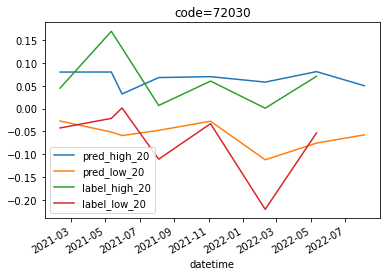

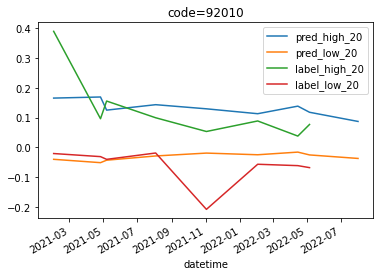

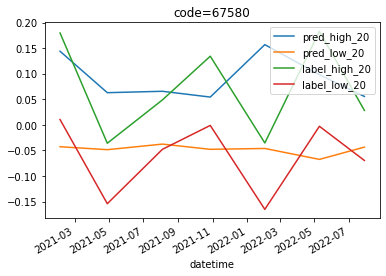

In [11]:
# ラベルもつけて描画してみる
for code in stock_codes:
  df_label = stock_labels[stock_labels["Local Code"]==code].copy()
  feat = ["base_date", "label_high_20", "label_low_20"]
  df_label = df_label[feat]
  df_label.columns = ["datetime", "label_high_20", "label_low_20"]

  df_label["datetime"] = pd.to_datetime(df_label["datetime"])
  df_label = df_label.set_index(["datetime"])

  result_to_draw = result[result.index>=test_start_dt].copy()
  result_to_draw = result_to_draw.reset_index()
  result_to_draw = result_to_draw[result_to_draw["code"]==code].set_index("datetime")
  result_to_draw = result_to_draw[["pred_high_20","pred_low_20"]]

  result_to_draw = pd.concat([result_to_draw, df_label[df_label.index.isin(result_to_draw.index)]], axis=1)
  result_to_draw.plot.line(title="code={}".format(code))
  result_to_draw


これでチュートリアルは終了です。お疲れ様でした！